# Sentiment analysis of US McDonald's reviews using a BERT and a VADER model

## Install libraries

In [1]:
!pip install transformers
!pip install torch
!pip install vaderSentiment

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## Set up dataframe

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('donken.csv', encoding='latin-1')#had to use latin-1 because utf-8 could not read some characters
df.head()

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star


## Set up sentiment models

In [3]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

tokenizer = BertTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
bert = BertForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

## Set up preprocess

In [4]:
import spacy
nlp = spacy.load('en_core_web_sm')
def preprocess(text):
    """
    lemmatizes the text and removes stopwords and words that are  not only letters
    """
    doc = nlp(text)
    tokens = ""
    for token in doc:
        if token.text.isalpha() and not token.is_stop:
            if len(tokens) > 0:
                tokens = tokens + " " + token.lemma_
            else:
                tokens = tokens + token.lemma_
    return tokens
preprocess(df['review'][0])

'look like spit food normal transaction chill polite nt want eat m try think milky white clear substance food d sure come'

## Preprocess the reviews

In [5]:
preprocessed = []
for rev in df.itertuples():
    rev_txt = rev.review
    if not isinstance(rev_txt, str):
        rev_txt = ""
    
    preprocessed.append(preprocess(rev_txt))
print(preprocessed[:10])    

['look like spit food normal transaction chill polite nt want eat m try think milky white clear substance food d sure come', 'McDonalds far food atmosphere staff difference friendly accommodate smile make pleasant experience fast food place', 'mobile order get speaker check line move leave late work get refund app call say money person stick system go person day manager tell wasnï', 'mc Crispy chicken sandwich customer service quick p', 'repeat order time drive manage mess suppose large meal double filet fish large fry cheese wrong need pay close attention order understand English need work drive', 'work door dash lock wait long line reason try beg open door dash refuse Covid new job', 'location zero customer service pull drive place simple order order regular hamburg cookie pay pull window pick tell pull space sit sit minute later order go counter yell hello time young lady come ask handle counter young girl appear complaint short show receipt minute later get order order drink sit co

## BERT sentiments function


In [6]:
def bert_analysis(rev):
    tokens = tokenizer.encode(rev, return_tensors='pt')
    sentiment = bert(tokens)
    return int(torch.argmax(sentiment.logits))+1 #add one to match the rating system in the dataset

## Vader sentiments function

In [7]:
def vader_analysis(rev):
    vader_analyzer = SentimentIntensityAnalyzer()
    vader_scores = vader_analyzer.polarity_scores(rev)
    compound_score = vader_scores['compound']
    vader_sentiment = round((compound_score+1)*2+1)
    return vader_sentiment

## Get the sentiments

In [8]:
bert_sentiments = []
vader_sentiments = []
for rev in preprocessed:
    bert_sent = bert_analysis(rev)
    bert_sentiments.append(bert_sent)
    vader_sent = vader_analysis(rev)
    vader_sentiments.append(vader_sent)
df.insert(10, "BERT_sentiment", bert_sentiments, True) #add BERT sentiments to the dataframe
df.insert(11, "VADER_sentiment", vader_sentiments, True) #add VADER sentiments to the dataframe
df.head()

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating,BERT_sentiment,VADER_sentiment
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star,1,5
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars,4,5
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star,1,3
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars,5,3
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star,1,2


## Get the average ratings for each resturant based on the review ratings, the BERT and VADER sentiments

In [10]:
import re
res_rating = {}
res_bert_sentiment = {}
res_vader_sentiment = {}
for i in range(len(df['store_address'])):
    key = df['store_address'][i]
    if key not in res_rating:
        res_rating[key] = int(df['rating'][i][0]) 
        res_bert_sentiment[key] = bert_sentiments[i]  
        res_vader_sentiment[key] = vader_sentiments[i] 
    else:
        res_rating[key] += int(df['rating'][i][0]) 
        res_bert_sentiment[key] += bert_sentiments[i]
        res_vader_sentiment[key] += vader_sentiments[i]
for res in res_rating.keys():
    skip_special = re.escape(res) #escapes the special chars in the string
    count = df['store_address'].str.contains(skip_special).sum() 
    res_rating[res] = res_rating[res]/count
    res_bert_sentiment[res] = res_bert_sentiment[res]/count
    res_vader_sentiment[res] = res_vader_sentiment[res]/count
    
print(res_rating)
print(res_bert_sentiment)
print(res_vader_sentiment)

{'13749 US-183 Hwy, Austin, TX 78750, United States': 3.1925, '1698 US-209, Brodheadsville, PA 18322, United States': 3.463035019455253, '72-69 Kissena Blvd, Queens, NY 11367, United States': 3.2859649122807015, '429 7th Ave, New York, NY 10001, United States': 3.692105263157895, '724 Broadway, New York, NY 10003, United States': 3.312280701754386, '160 Broadway, New York, NY 10038, United States': 2.3333333333333335, '555 13th St NW, Washington, DC 20004, United States': 2.6666666666666665, '10451 Santa Monica Blvd, Los Angeles, CA 90025, United States': 3.6666666666666665, '114 Delancey St, New York, NY 10002, United States': 3.3333333333333335, '5920 Balboa Ave, San Diego, CA 92111, United States': 3.598181818181818, '262 Canal St, New York, NY 10013, United States': 3.1259259259259258, '490 8th Ave, New York, NY 10001, United States': 2.9597701149425286, '550 Lawrence Expy, Sunnyvale, CA 94086, United States': 3.33, '11382 US-441, Orlando, FL 32837, United States': 3.16478873239436

## Plot the average review ratings of the dataset

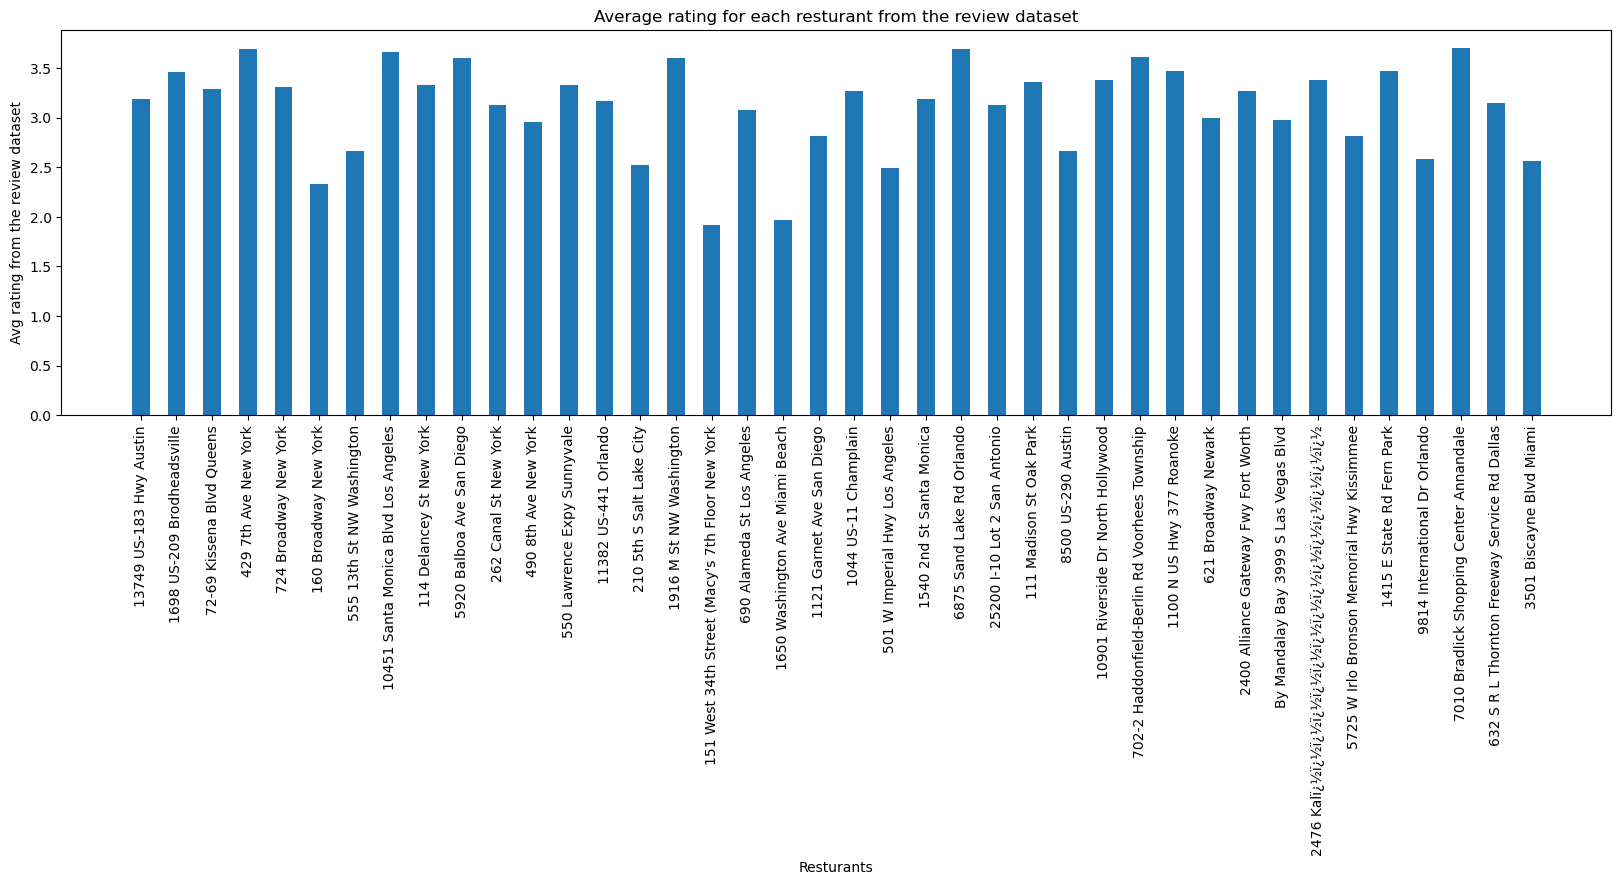

In [17]:
import matplotlib.pyplot as plt
resturants=[]
keys = list(res_rating.keys())
for key in keys:
    resturant = key.split(',') 
    if len(resturant) >= 2:
        val = resturant[0] + resturant[1]
    else:
        val = resturant[0]
    resturants.append(val)

ratings = list(res_rating.values())

fig = plt.figure(figsize=(20,5))

plt.bar(resturants, ratings, width = 0.5)
plt.title("Average rating for each resturant from the review dataset")
plt.ylabel("Avg rating from the review dataset")
plt.xlabel("Resturants")
plt.xticks(rotation=90, ha='center', va='top')

plt.show()


##  Plot the average BERT sentiment scores of each resturant

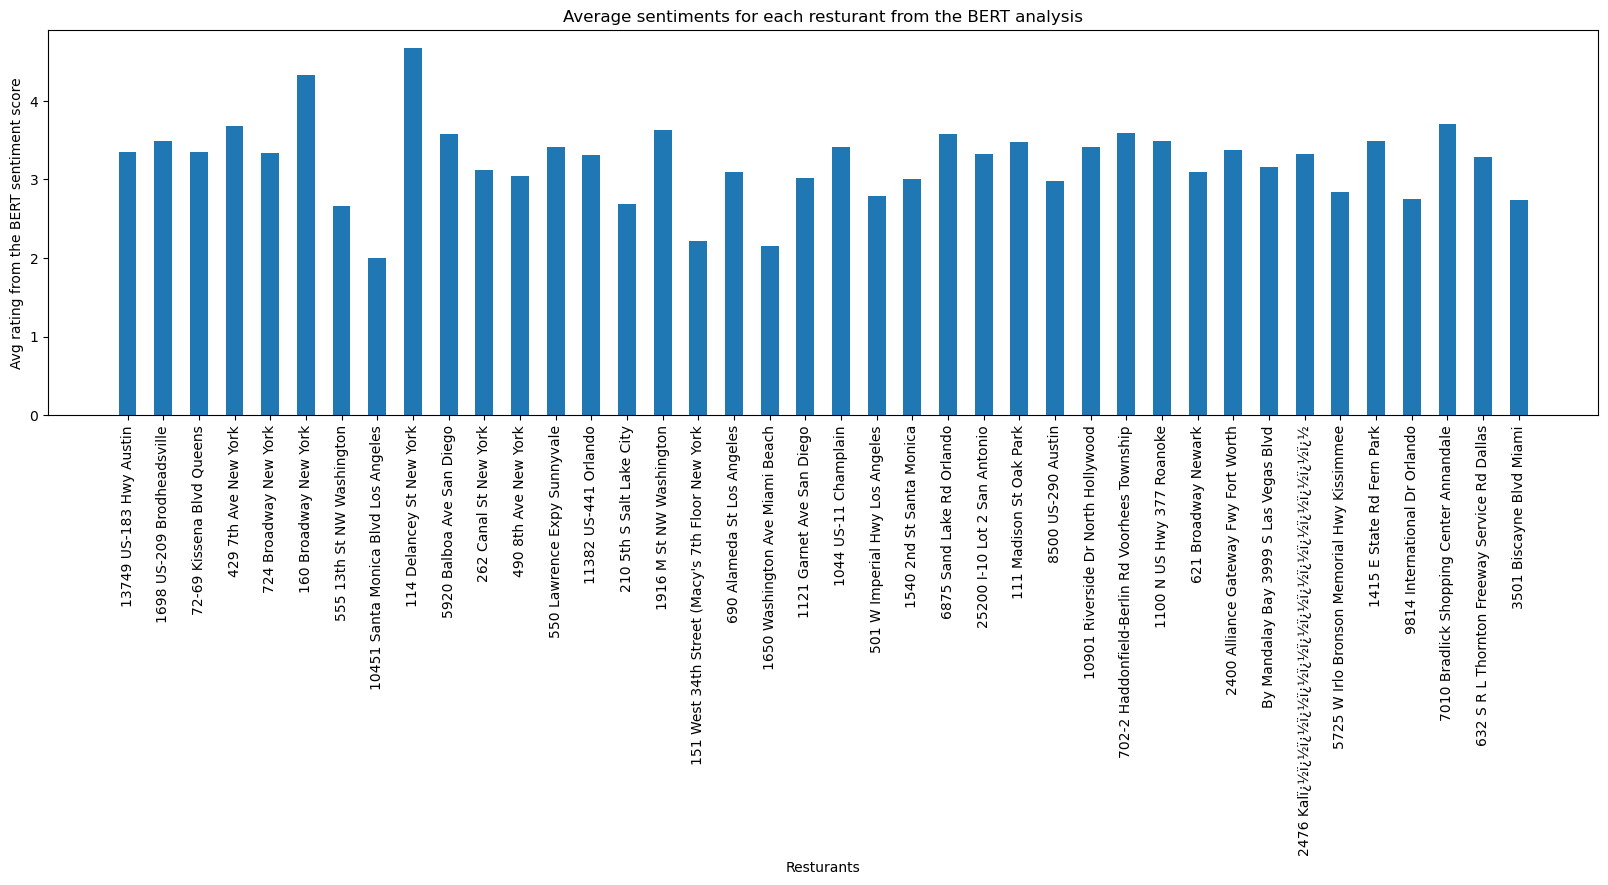

In [19]:
bert_scores = list(res_bert_sentiment.values())

fig = plt.figure(figsize=(20,5))

plt.bar(resturants, bert_scores, width = 0.5)
plt.title("Average sentiments for each resturant from the BERT analysis")
plt.ylabel("Avg rating from the BERT sentiment score")
plt.xlabel("Resturants")
plt.xticks(rotation=90, ha='center', va='top')
plt.show()

## Plot the average VADER sentiment scores of each resturant

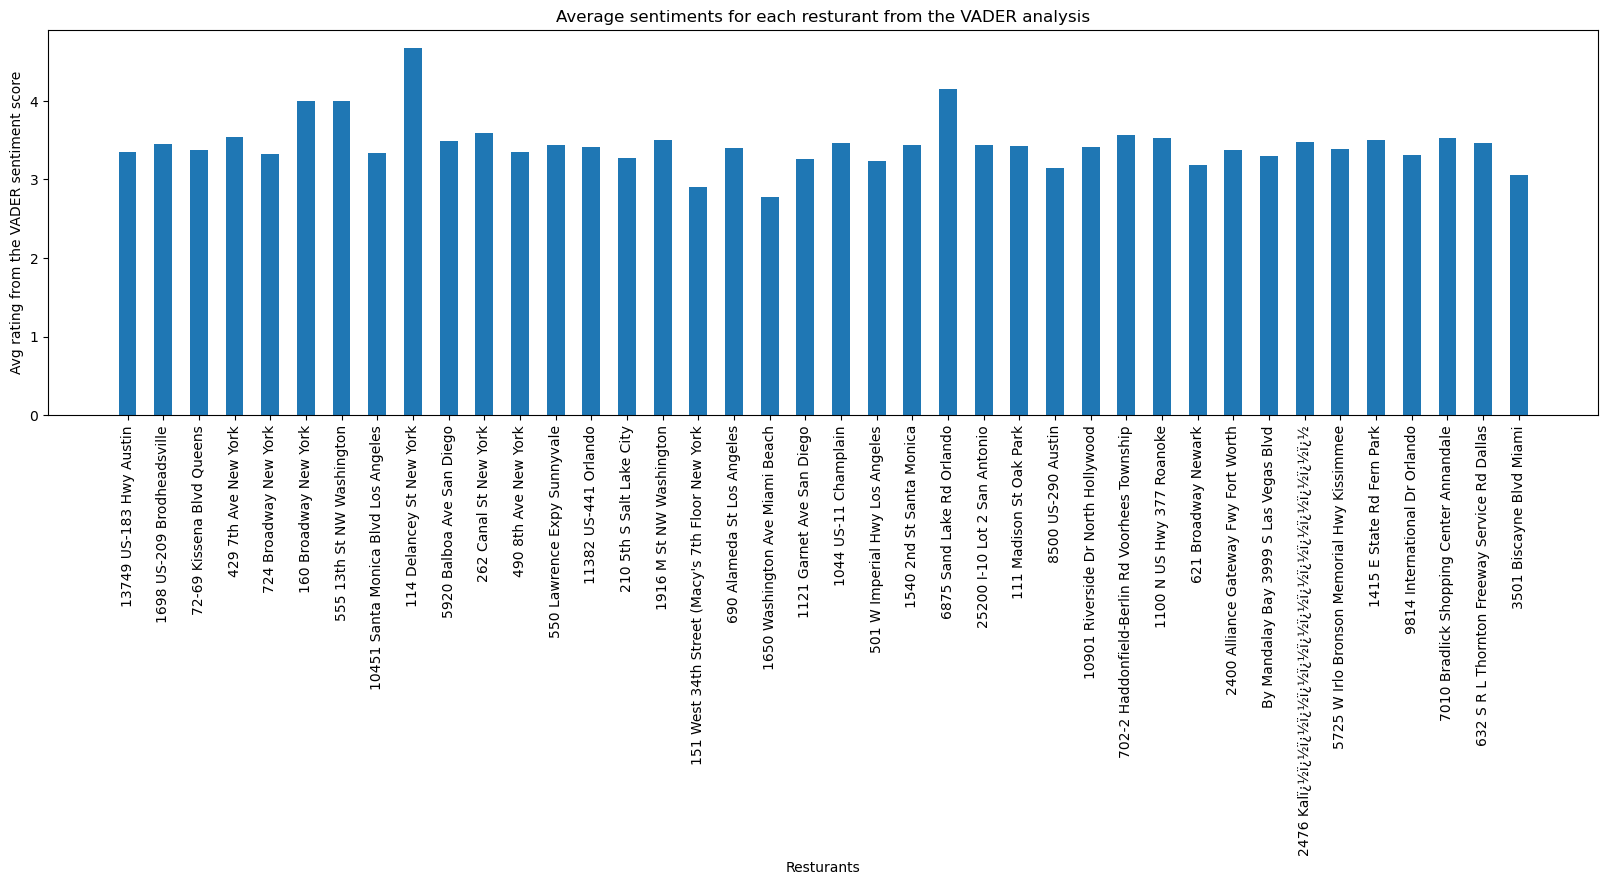

In [20]:
vader_scores = list(res_vader_sentiment.values())

fig = plt.figure(figsize=(20,5))

plt.bar(resturants, vader_scores, width = 0.5)
plt.title("Average sentiments for each resturant from the VADER analysis")
plt.ylabel("Avg rating from the VADER sentiment score")
plt.xlabel("Resturants")
plt.xticks(rotation=90, ha='center', va='top')
plt.show()

## Find the best and worst rated resturants according to the ratings and the models

In [22]:
best_rating = max(res_rating, key=res_rating.get)
best_bert = max(res_bert_sentiment, key=res_bert_sentiment.get)
best_vader = max(res_vader_sentiment, key=res_vader_sentiment.get)
worst_rating = min(res_rating, key=res_rating.get)
worst_bert = min(res_bert_sentiment, key=res_bert_sentiment.get)
worst_vader = min(res_vader_sentiment, key=res_vader_sentiment.get)

print(best_rating, "has the highest average review grade:", res_rating[best_rating])
print(worst_rating, "has the lowest average review grade:", res_rating[worst_rating])
print(best_bert, "has the highest average BERT score:", res_bert_sentiment[best_bert])
print(worst_bert, "has the lowest average BERT score:", res_bert_sentiment[worst_bert])
print(best_vader, "has the highest average VADER score:", res_vader_sentiment[best_vader])
print(worst_vader, "has the lowest average VADER score:", res_vader_sentiment[worst_vader])


7010 Bradlick Shopping Center, Annandale, VA 22003, United States has the highest average review grade: 3.697674418604651
151 West 34th Street (Macy's 7th Floor, New York, NY 10001, United States has the lowest average review grade: 1.9166666666666667
114 Delancey St, New York, NY 10002, United States has the highest average BERT score: 4.666666666666667
10451 Santa Monica Blvd, Los Angeles, CA 90025, United States has the lowest average BERT score: 2.0
114 Delancey St, New York, NY 10002, United States has the highest average VADER score: 4.666666666666667
1650 Washington Ave, Miami Beach, FL 33139, United States has the lowest average VADER score: 2.778947368421053


## plotting the best and worst averages

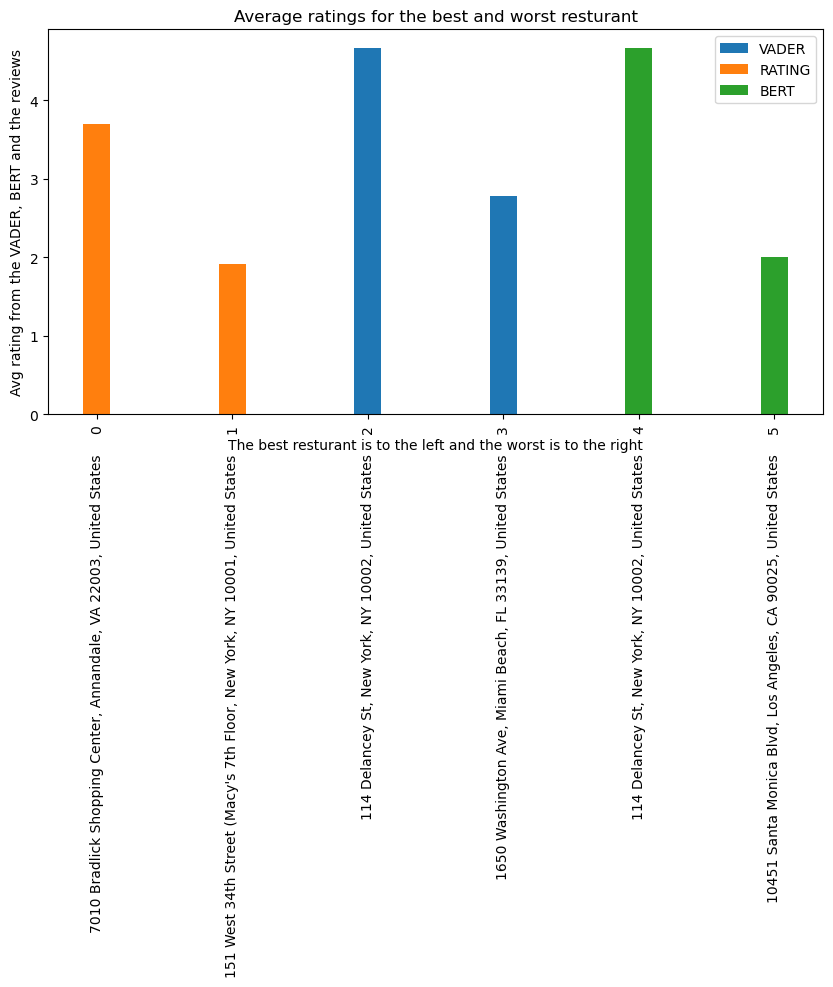

In [35]:
vader = [res_vader_sentiment[best_vader],res_vader_sentiment[worst_vader]]
bert = [res_bert_sentiment[best_bert], res_bert_sentiment[worst_bert]]
rating = [res_rating[best_rating], res_rating[worst_rating]]
names = [best_rating, worst_rating, best_vader, worst_vader, best_bert, worst_bert]
X=['best_rating', 'worst_rating', 'best_vader,' , 'worst_vader', 'best_bert', 'worst_bert']
X_axis = np.arange(len(X))
fig = plt.figure(figsize=(10,5))

plt.bar(X_axis[2:4], vader, width=0.2, label='VADER')
plt.bar(X_axis[:2], rating, width=0.2, label='RATING')
plt.bar(X_axis[4:], bert, width=0.2, label='BERT')
plt.title("Average ratings for the best and worst resturant")
plt.ylabel("Avg rating from the VADER, BERT and the reviews")
plt.xlabel("The best resturant is to the left and the worst is to the right")
plt.legend() 
plt.xticks(X_axis, rotation=90, ha='center', va='top')
for i, name in enumerate(names):
    plt.text(X_axis[i] , -0.5, name, rotation=90, ha='center', va='top')
plt.show()

## Compare how the best and worst rated resturants were interpreted by the models

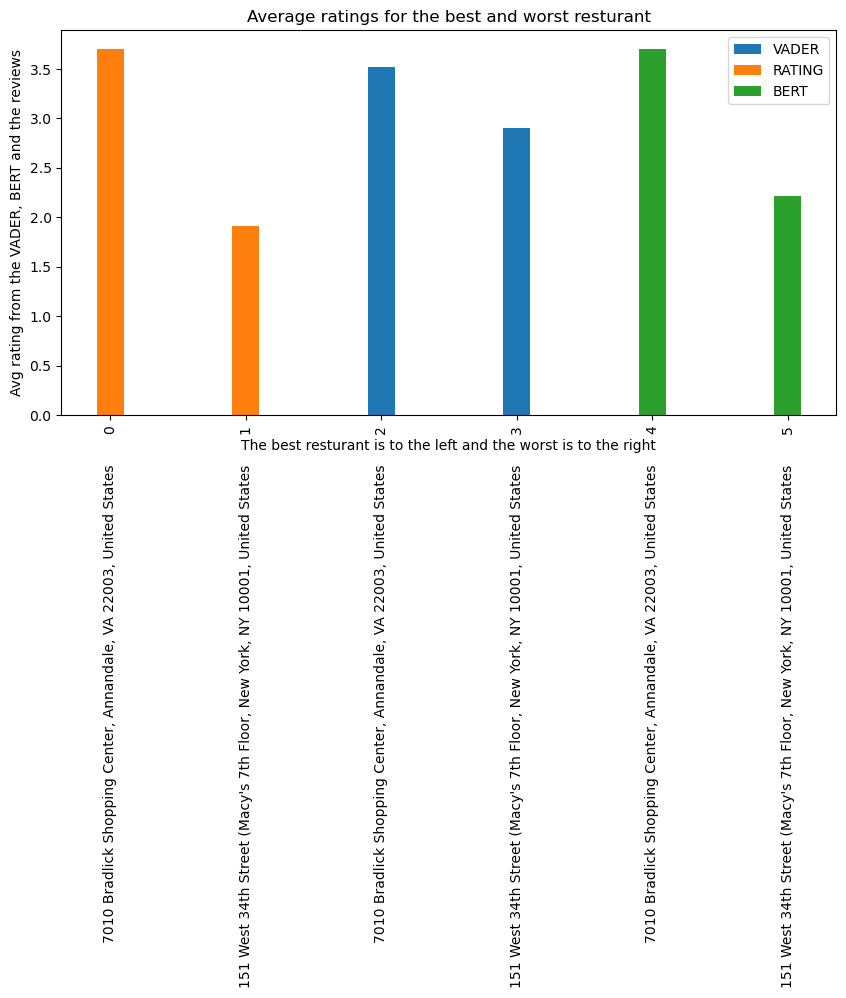

In [37]:
vader = [res_vader_sentiment[best_rating],res_vader_sentiment[worst_rating]]
bert = [res_bert_sentiment[best_rating], res_bert_sentiment[worst_rating]]
rating = [res_rating[best_rating], res_rating[worst_rating]]
names = [best_rating, worst_rating, best_rating, worst_rating, best_rating, worst_rating]
X=['best_rating', 'worst_rating', 'best_rating', 'worst_rating', 'best_rating', 'worst_rating']
X_axis = np.arange(len(X))
fig = plt.figure(figsize=(10,5))

plt.bar(X_axis[2:4], vader, width=0.2, label='VADER')
plt.bar(X_axis[:2], rating, width=0.2, label='RATING')
plt.bar(X_axis[4:], bert, width=0.2, label='BERT')
plt.title("Average ratings for the best and worst resturant")
plt.ylabel("Avg rating from the VADER, BERT and the reviews")
plt.xlabel("The best resturant is to the left and the worst is to the right")
plt.legend() 
plt.xticks(X_axis, rotation=90, ha='center', va='top')
for i, name in enumerate(names):
    plt.text(X_axis[i] , -0.5, name, rotation=90, ha='center', va='top')
plt.show()

## Generate classification reports for the BERT and VADER models

In [36]:
from sklearn.metrics import classification_report
rating_ints=[]
for rating in df['rating']:
    rating_ints.append(int(rating[0]))
report_bert = classification_report(rating_ints, df['BERT_sentiment'])
report_vader = classification_report(rating_ints, df['VADER_sentiment'])
print(report_bert)
print(report_vader)

              precision    recall  f1-score   support

           1       0.69      0.75      0.72      9431
           2       0.23      0.08      0.11      3086
           3       0.49      0.37      0.42      4818
           4       0.39      0.54      0.46      5787
           5       0.64      0.65      0.65     10274

    accuracy                           0.57     33396
   macro avg       0.49      0.48      0.47     33396
weighted avg       0.55      0.57      0.55     33396

              precision    recall  f1-score   support

           1       0.87      0.15      0.25      9431
           2       0.19      0.34      0.25      3086
           3       0.28      0.51      0.36      4818
           4       0.26      0.61      0.37      5787
           5       0.57      0.22      0.32     10274

    accuracy                           0.32     33396
   macro avg       0.44      0.37      0.31     33396
weighted avg       0.52      0.32      0.31     33396

